In [13]:
import sys
sys.path.append("..")

In [14]:
import pymde
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.model import create_model
from src.transform import Transform
from src.monitor import DomainShiftMonitor
from src.dataset import InferenceDataset, TrainDataset

In [15]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

In [16]:
model = create_model(
    model_name="resnet18",
    pretrained=True,
    num_classes=10
)

> Created resnet18 with pretrained weights. Num classes set to 10.


In [17]:
imagenette_dataset = TrainDataset(
    root_dir="/Users/riccardomusmeci/Developer/data/github/imagenette2-320",
    train=True,
    class_map={
        0: 'n03888257-parachute',
        1: 'n02979186-player',
        2: 'n03417042-truck',
        3: 'n03425413-distributor',
        4: 'n03445777-ball',
        5: 'n03028079-church',
        6: 'n02102040-dog',
        7: 'n01440764-fish',
        8: 'n03394916-trumpet',
        9: 'n03000684-chainsaw'
    },
    max_samples_per_class=500,
    random_samples=True,
    transform=Transform(train=False, img_size=224)
)

> Train dataset sanity check OK
> Images will be limited from 960 to 500 (selected randomnly) for label 0 (n03888257-parachute)
> Images will be limited from 993 to 500 (selected randomnly) for label 1 (n02979186-player)
> Images will be limited from 961 to 500 (selected randomnly) for label 2 (n03417042-truck)
> Images will be limited from 931 to 500 (selected randomnly) for label 3 (n03425413-distributor)
> Images will be limited from 951 to 500 (selected randomnly) for label 4 (n03445777-ball)
> Images will be limited from 941 to 500 (selected randomnly) for label 5 (n03028079-church)
> Images will be limited from 955 to 500 (selected randomnly) for label 6 (n02102040-dog)
> Images will be limited from 963 to 500 (selected randomnly) for label 7 (n01440764-fish)
> Images will be limited from 956 to 500 (selected randomnly) for label 8 (n03394916-trumpet)
> Images will be limited from 858 to 500 (selected randomnly) for label 9 (n03000684-chainsaw)
 ----------- Dataset Train Stats --

In [18]:
imagewang_dataset = TrainDataset(
    root_dir="/Users/riccardomusmeci/Developer/data/github/imagewang",
    train=True,
    class_map={
        0: 'n02086240',
        1: 'n02087394',
        2: 'n02088364',
        3: 'n02089973',
        4: 'n02093754',
        5: 'n02096294',
        6: 'n02099601',
        7: 'n02105641',
        8: 'n02111889',
        9: 'n02115641'
    },
    max_samples_per_class=500,
    random_samples=True,
    transform=Transform(train=False, img_size=224)
)

> Train dataset sanity check OK
 ----------- Dataset Train Stats -----------
> ['n02086240'] : 142/1275 -> 11.137%
> ['n02087394'] : 119/1275 -> 9.333%
> ['n02088364'] : 141/1275 -> 11.059%
> ['n02089973'] : 75/1275 -> 5.882%
> ['n02093754'] : 146/1275 -> 11.451%
> ['n02096294'] : 147/1275 -> 11.529%
> ['n02099601'] : 127/1275 -> 9.961%
> ['n02105641'] : 126/1275 -> 9.882%
> ['n02111889'] : 138/1275 -> 10.824%
> ['n02115641'] : 114/1275 -> 8.941%
 -------------------------------------


In [19]:
monitor = DomainShiftMonitor(
    model=model,
    datasets=[imagenette_dataset, imagewang_dataset],
    target_layers=["global_pool.pool"],
    verbose=False
)

> Creating model monitor to get embeddings at specific layers.
Adding global_pool.pool to monitor with hooks.
[SUCCESS] Layer 'global_pool.pool' found!


In [20]:
layers_dist = monitor.estimate()

> Extracting embedding for the first dataset.


100%|██████████| 157/157 [00:33<00:00,  4.65it/s]


> Extracting embedding for the second dataset.


100%|██████████| 40/40 [00:11<00:00,  3.61it/s]


> Estimating domain shift for layer: global_pool.pool
> Dataset 1 embedding shape: (5000, 512)
> Dataset 2 embedding shape: (1275, 512)
Representation shift using wasserstein distance:  0.03483099457764822


In [21]:
X, y = layers_dist["global_pool.pool"].values()
X.shape, y.shape

((6275, 512), (6275,))

In [22]:
embedding = pymde.preserve_neighbors(
    X, 
    verbose=True, 
    embedding_dim=2
).embed()

Oct 29 12:40:36 PM: Computing 15-nearest neighbors, with max_distance=None
Oct 29 12:40:36 PM: Exact nearest neighbors by brute force 
Oct 29 12:40:37 PM: Computing quadratic initialization.


/Users/riccardomusmeci/Developer/code/github/classifier-playground/venv/lib/python3.8/site-packages/pymde/problem.py:150: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  complete_graph_edges = n_items * (n_items - 1) // 2


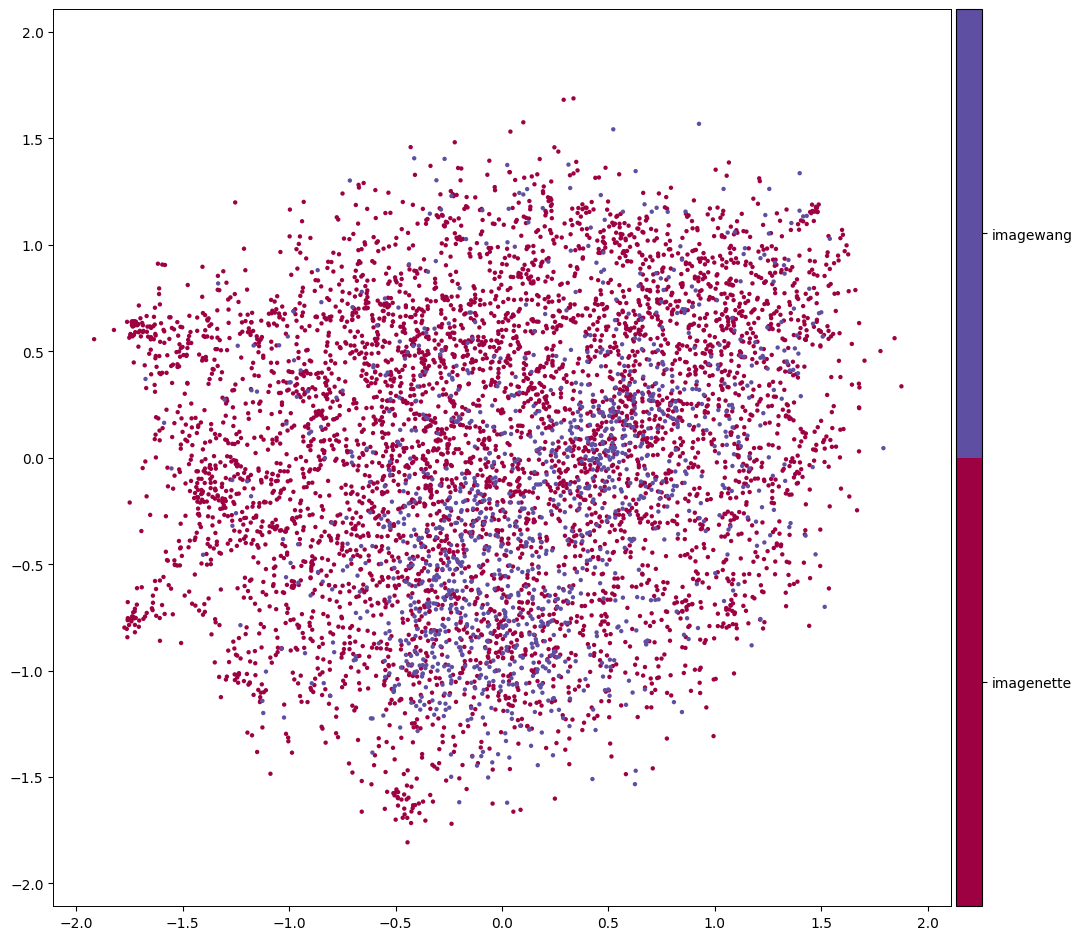

In [24]:
pymde.plot(
    embedding, 
    color_by=["imagenette" if el == 0 else "imagewang" for el in y], 
    figsize_inches=(10, 10), 
    marker_size=10.0, 
);